---
# California_Housing_Prediction

<font size="4"> 

En este trabajo se usan datos provenientes de un censo de Estados Unidos. El objetivo es predecir el **valor medio de las viviendas** en distritos de California, basándose en características demográficas y geográficas. Las variables principales incluyen:

* **Geografía:** Latitud y longitud del distrito.
* **Demografía:** Población total, número de hogares y el ingreso medio de los habitantes.
* **Vivienda:** Edad promedio de las casas en el bloque, total de habitaciones y total de dormitorios.
* **Objetivo (Target):** El valor medio de la casa (expresado generalmente en cientos de miles de dólares).

A continuación, se presenta un análisis exploratorio de datos.

</font>

---
# Análisis Exploratorio De Datos
<font size="4"> Para comenzar, se importan las librerias necesarias para esta tarea:</font>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split

<font size="4"> se cargan los datos:</font>

In [2]:
df=pd.read_csv('/kaggle/input/housing/housing.csv')

<font size="4"> Se obtiene la información del conjunto de datos:</font>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<font size="4"> Verifico que no haya duplicados:</font>

In [4]:
df.duplicated().sum()

np.int64(0)

<font size="4"> 

Con base en la información inicial. Este conjunto de datos contiene la información de **20640 ubicaciones**. Cuenta con variables de tipo

* **Geográficas**: longitude y latitude (Ubicación exacta del distrito).
* **Demográficas**: housing_median_age, total_rooms, total_bedrooms, population y households.
* **Económicas**: median_income (Ingreso medio) y median_house_value (Variable objetivo, usualmente lo que queremos predecir).

También cuenta con una variable de tipo categórica que indica la proximidad de la ubicación con respecto al oceano (ocean_proximity).

De acuerdo con las instrucciones del examen, solo se consideraban 6 variables predictoras pero también contamos con **households** y **median_income**. Incluso podría considerarse **ocean_proximity** si se codifica.

Ya que **total_bedrooms** cuenta con 207 valores nulos (20,433 vs 20,640), conforme avanzo decidiré si eliminarlo o imputarlo. 

Mientras tanto, mostraré las categorias de **ocean_proximity**:
</font>

In [5]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<font size="4">

El 76% de las ubicaciones están distribuidas en dos categorias: aquellas a menos de una hora del océano (9,136 propiedades) y las ubicadas en zonas del interior (6,551). El resto se divide entre propiedades cerca del océano (2,658) y cerca de bahías (2,290). La isla solo cuenta con 5 viviendas, por lo que su relevancia podría ser nula. Para efectos practicos, se crea una nueva columna codificada de **ocean_proximity_num**:

</font>

In [6]:
df['ocean_proximity_num'] = df['ocean_proximity'].astype('category').cat.codes

<font size="4">

Ahora obtengo los histogramas de las columnas para analizar la distribución estadística de los datos





</font>

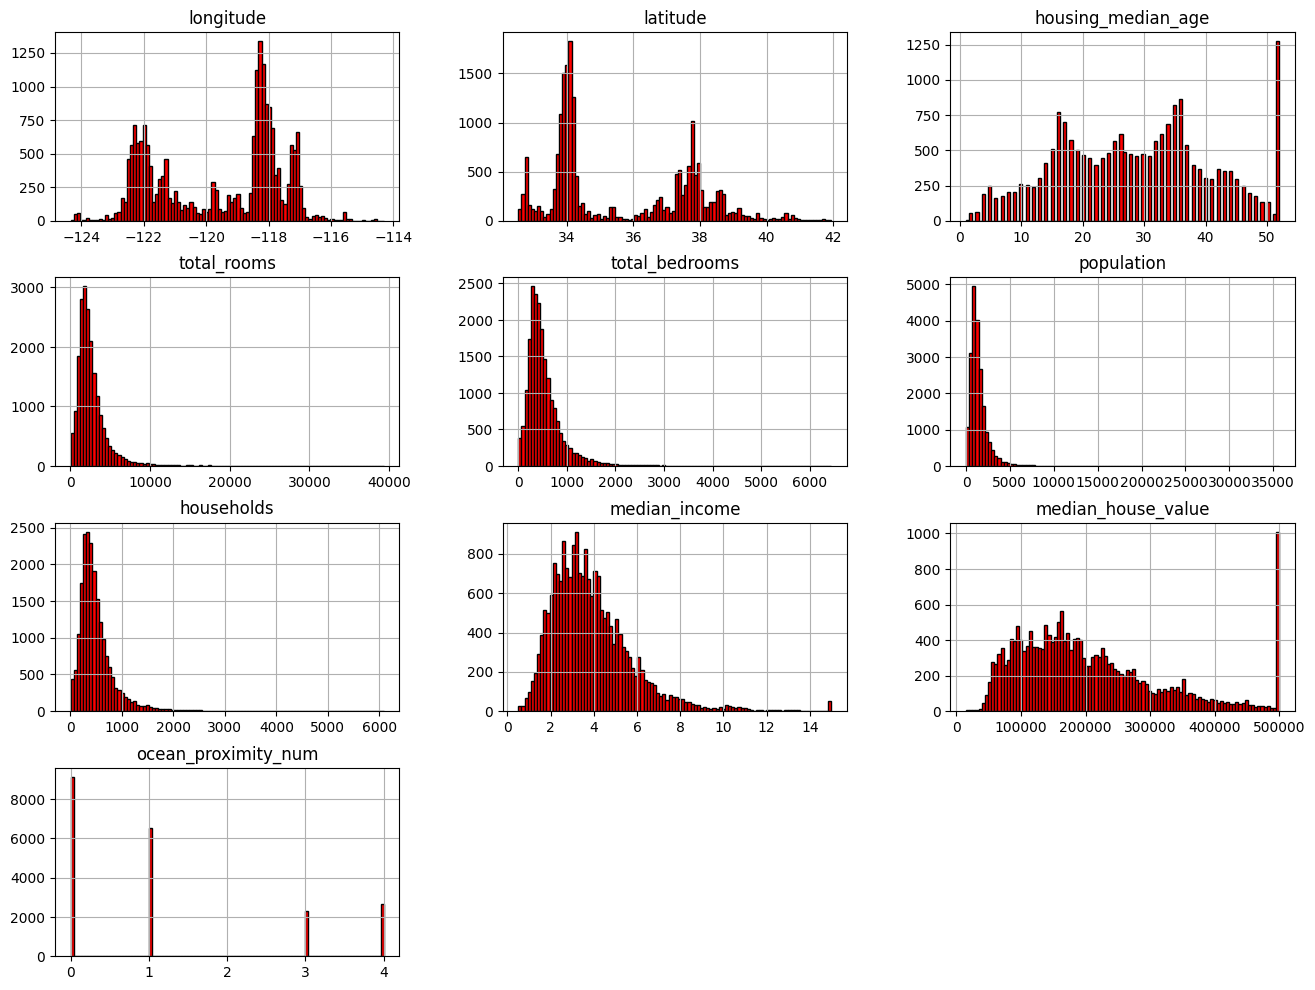

In [7]:
df.hist(bins=100, figsize=(16, 12), color='red', edgecolor='black');

In [8]:
df[['housing_median_age', 'median_house_value']].describe()

,housing_median_age,median_house_value
count,20640.000000,20640.000000
mean,28.639486,206855.816909
std,12.585558,115395.615874
min,1.000000,14999.000000
25%,18.000000,119600.000000
50%,29.000000,179700.000000
75%,37.000000,264725.000000
max,52.000000,500001.000000


<font size="4">

En los histogramas se observa sesgo positivo en variables como precio, ingreso y número de habitaciones, lo cual es característico de distribuciones económicas. Particularmente, **housing_median_age** y **median_house_value** presentan acumulación de datos en sus valores extremos. Si bien el primero podría reflejar la antigüedad verdadera de las primeras construcciones (52 años), en el segundo caso, el valor está limitado a $500,001 de acuerdo con el resumento estadístico, Este límite impuesto podemos observarlo en el siguiente **gráfico de dispersión**:

</font >

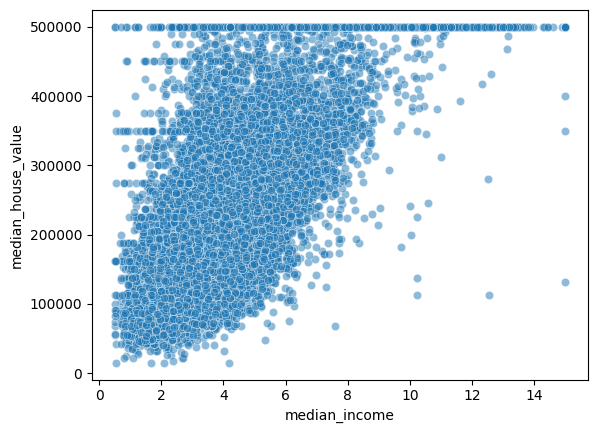

In [9]:
sns.scatterplot(data=df, x='median_income', y='median_house_value', alpha=0.5);

In [10]:
len(df[df['median_house_value'] == 500001])

965

<font size="4">

Aqui tenemos un caso de interés porque hay 965 instancias en las que no refleja el valor real de mercado de esas viviendas, sino un valor máximo topado a $500,001. Estas instancias actúan como ruido para el modelo. Al no conocer el valor real por encima de ese límite, el algoritmo aprendería un sesgo incorrecto. Por lo tanto, decidí filtrar el dataset para mejorar la capacidad de generalización
</font>

In [11]:
df = df[df['median_house_value'] < 500001]

<font size="4">

Ahora analizaré las correlaciones de Pearson y Spearman:

</font>

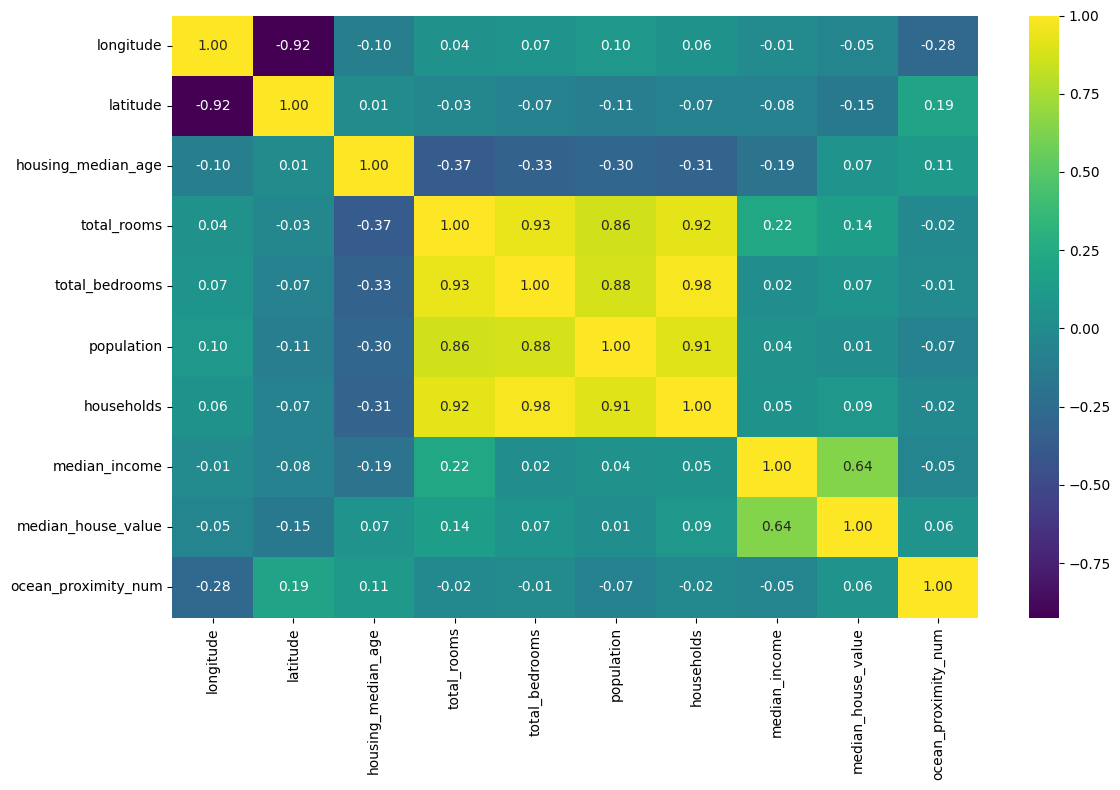

In [12]:
plt.figure(figsize=(12, 8)); sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='viridis', fmt='.2f'); plt.tight_layout()

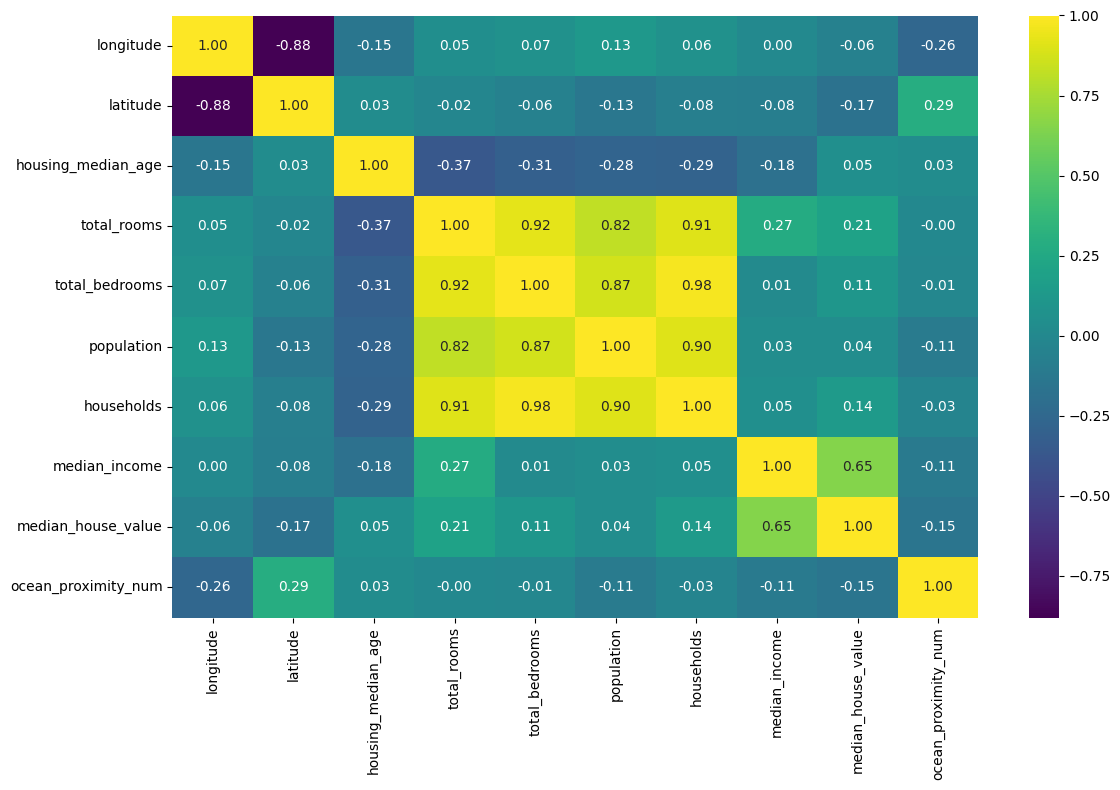

In [13]:
plt.figure(figsize=(12, 8)); sns.heatmap(df.select_dtypes(include=['number']).corr(method='spearman'), annot=True, cmap='viridis', fmt='.2f'); plt.tight_layout()

<font size="4">
    
El recuadro de amarillo con las 4 caracteristicas total_rooms, total_bedrooms, population y households, capturan información similar. La característica que hasta ahora muestra mayor capacidad para la tarea de regresión es el ingreso (median_income). Por otro lado, la fuerte relación negativa entre latitud y longitud es simplemente un reflejo de la distrubución geográfica a como se muestra en el mapa:

</font>

In [14]:
fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="median_house_value", 
                        size="population",
                        color_continuous_scale='viridis',
                        size_max=15, 
                        zoom=5,
                        mapbox_style="carto-positron",
                        hover_data={'latitude': True, 'longitude': True, 'median_income': True})

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

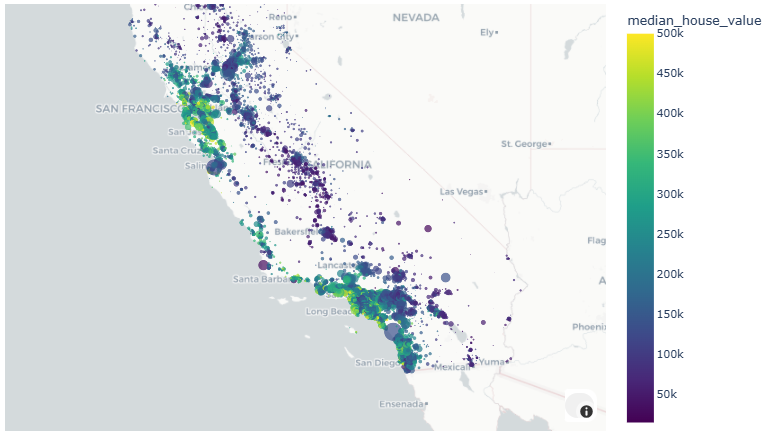

Ahora voy a crear nuevas columnas a partir de las características colineales:

count    19675.000000
mean         3.095189
std         10.631977
min          0.692308
25%          2.445486
50%          2.837134
75%          3.304894
max       1243.333333
Name: ratio_habitantes_casa, dtype: float64

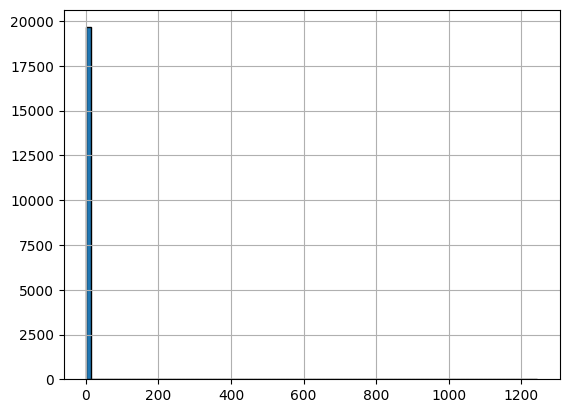

In [15]:
df['ratio_habitantes_casa'] = df['population'] / df['households']
df['ratio_habitantes_casa'].hist(bins=100, edgecolor='black')
df['ratio_habitantes_casa'].describe()

In [16]:
percentiles = np.arange(90, 101, 1)
valores = df['ratio_habitantes_casa'].quantile(percentiles / 100)


resumen_percentiles = pd.DataFrame({
    'Percentil': percentiles,
    'Valor': valores.values
})

resumen_percentiles

,Percentil,Valor
0,90,3.911693
1,91,3.983763
2,92,4.076536
3,93,4.156761
4,94,4.250000
5,95,4.353335
6,96,4.475626
7,97,4.653733
8,98,4.883721
9,99,5.412602


<font size="4">
    
Respecto al número promedio de habitantes por casa **ratio_habitantes_casa** se identificó un salto de 5.4 a 1243 habitantes entre el percentil 99 y 100. Para tomar una decisión basada en críterios estadísticos, se usará el **Identificador de Hampel**: un método de detección de anomalías que utiliza la mediana y la desviación absoluta de la mediana en lugar de la media y la desviación estándar. Su principal ventaja es que no se deja sesgar por los propios valores atípicos. Se seleccionó un multiplicador de $k=4$ para ajustar la sensibilidad del filtro al contexto demográfico del dataset:

</font>

In [17]:
def detectar_limite_hampel(df, col, t0=4):
    """
    Retorna el umbral superior basado en el Identificador de Hampel.
    t0: número de desviaciones (3 es el estándar).
    """
    mediana = df[col].median()
    
    # desviación absoluta respecto a la mediana
    mad = np.median(np.abs(df[col] - mediana))
    
    # Factor de escala para consistencia con distribución normal
    L = 1.4826 
    
    umbral_superior = mediana + (t0 * L * mad)
    
    return umbral_superior

<font size="4">
    
Para el **ratio_habitantes_casa**, tenemos que el **límite Hampel** es:

</font>

In [18]:
limite = detectar_limite_hampel(df, 'ratio_habitantes_casa')
print(f"Límite estadístico sugerido por Hampel: {limite:.2f}")

Límite estadístico sugerido por Hampel: 5.35


<font size="4">

En este contexto, el límite de Hampel (5.35) es muy similar al valor del percentil 99 (5.41). Eso implica una convergencia hacia 5.4, por lo tanto, este valor podría representar el límite natural de la distribución. Fijar este valor como máximo mantiene consistencia entre la estadística de posición y la estimación de la dispersión. Entonces:

</font>

In [19]:
df = df[df['ratio_habitantes_casa'] <= df['ratio_habitantes_casa'].quantile(0.99)]

<font size="4">

Ahora creamos un ratio para pormedio del número de dormitorios por habitaciones:

</font>

In [20]:
df['ratio_dormitorios_habitaciones'] = df['total_bedrooms'] / df['total_rooms']

In [21]:
df['ratio_dormitorios_habitaciones'].describe()

count    19279.000000
mean         0.214638
std          0.056566
min          0.100000
25%          0.177482
50%          0.204340
75%          0.240595
max          1.000000
Name: ratio_dormitorios_habitaciones, dtype: float64

<font size="4">

El valor máximo (1) implica la existencia de registros donde el 100% de las habitaciones de la vivienda son dormitorios. Si bien esto es posible para un loft, aún así representa una inconsistencia, tomando en cuenta que la mayoría de las casas comunes tiene cocina, baño y sala. Esto puede observarse en el salto del percentil 99(0.4) al valor máximo (1). Basado en las experiencias previas, tomamos el percentil 99 con el valor límite (0.4)

</font>

In [22]:
df = df[df['ratio_dormitorios_habitaciones'] <= df['ratio_dormitorios_habitaciones'].quantile(0.99)]

<font size="4">
En este punto concluí el EDA, donde identifiqué y eliminé datos atípicos que no tenían sentido lógico, como distritos con registros de 1,243 habitantes promedio por vivienda y las casas con una sola habitación, que eran dormitorios básicamente. Estas observaciones son ruído que afectaría la capacidad de generalización del modelo si se hubiesen conservado.

El próximo paso es la limpieza y transformación de los datos. Para este proceso, se hará una división de datos y se imputarán los 207 valores faltantes en la columna total_bedrooms,utilizando la mediana del conjunto de prueba.
</font>

---
# LIMPIEZA DE DATOS

Aqui inicio separando las características de la variable objetivo

In [23]:
X = df.drop(["median_house_value", "ocean_proximity", "ocean_proximity_num"], axis=1)
y = df["median_house_value"].copy()

<font size="4">
    
Divido el conjunto para entrenamiento y prueba:

</font>

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<font size="4">
    
imputo con la mediana del conjunto de prueba:

</font>

In [25]:
mediana_total_bedrooms = X_train["ratio_dormitorios_habitaciones"].median()

# imputé con mediana
X_train["ratio_dormitorios_habitaciones"] = X_train["ratio_dormitorios_habitaciones"].fillna(mediana_total_bedrooms)
X_test["ratio_dormitorios_habitaciones"] = X_test["ratio_dormitorios_habitaciones"].fillna(mediana_total_bedrooms)

<font size="4">
    
En este punto ya tenemos datos limpios porque, a pesar de que el conjunto de datos aún presenta outliers estadísticos, como salarios muy elevados o casas de gran antigüedad, se ha decidido conservarlos. Para el propósito de este examen, esta decisión se justifica debido a que dichas anomalías representan casos reales del mercado inmobiliario.

</font>


---
# SELECCIÓN DE CARACTERÍTICAS

<font size="4">
    
Aqui para seleccionar las características al azar, preferí utilizar un Random Forest como filtro inteligente para identificar cuáles tenían más peso real en el precio de las casas. Apliqué un selector automático para obtener un ranking de importancia para las características.

</font>


In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# configuración y entrenamiento
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=1), threshold="median")
selector.fit(X_train, y_train)

# Ranking
importancias = selector.estimator_.feature_importances_

ranking = pd.Series(importancias, index=X_train.columns).sort_values(ascending=False)
print(ranking)

X_train_selected = selector.transform(X_train)

median_income                     0.466570
ratio_habitantes_casa             0.133250
longitude                         0.116019
latitude                          0.106160
ratio_dormitorios_habitaciones    0.058003
housing_median_age                0.055814
total_rooms                       0.017661
population                        0.016413
total_bedrooms                    0.015265
households                        0.014845
dtype: float64


<font size="4">
    
Con base en el ranking decidí conservar las primeras 4 características. Podría incluir más pero con mis experiencias previas, las mejoras ya serían marginales para aquellas con una importancia de 0.05.


</font>

---
# MODELADO DE DATOS

<font size="4">
    
Ahora que ya cuento con las características, mi primera opción para el modelo fue XGBoost debido a que maneja bien los datos atípicos:

</font>


RMSE validado (CV): $44,587.38
RMSE Final en Test Set: $46,283.18


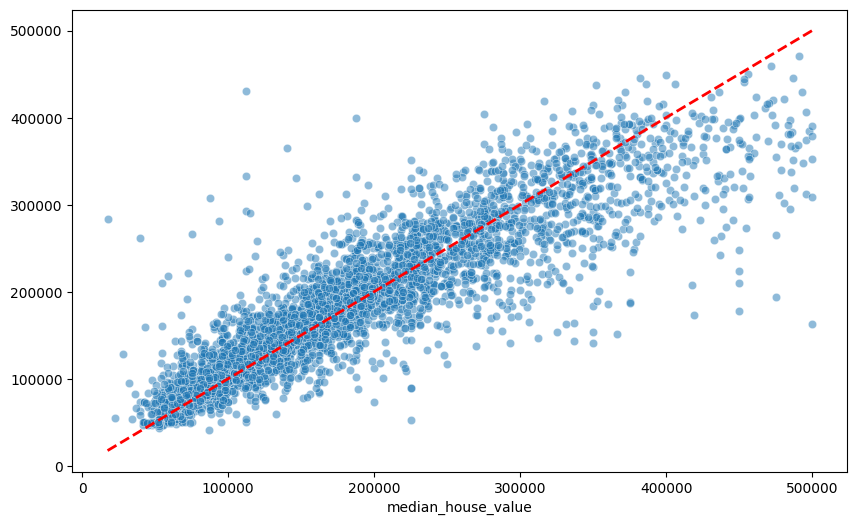

['model_xgb.pkl']

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib

# caracteristicas
features = ['median_income', 'ratio_habitantes_casa', 'longitude', 'latitude'] 

# configuración
final_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=1)

# 2. validación cruzada
scores = cross_val_score(final_xgb, X_train[features], y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"RMSE validado (CV): ${-scores.mean():,.2f}")

# entrenamiento
final_xgb.fit(X_train[features], y_train)

# predicciones
final_preds = final_xgb.predict(X_test[features])
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
print(f"RMSE Final en Test Set: ${final_rmse:,.2f}")

# Dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.show()

joblib.dump(final_xgb, 'model_xgb.pkl')

Como la actividad me pide dos modelos, seleccioné regresión lineal para contrastar los resultados:

RMSE validado (CV): $60,400.83
RMSE Final en Test Set: $61,725.10


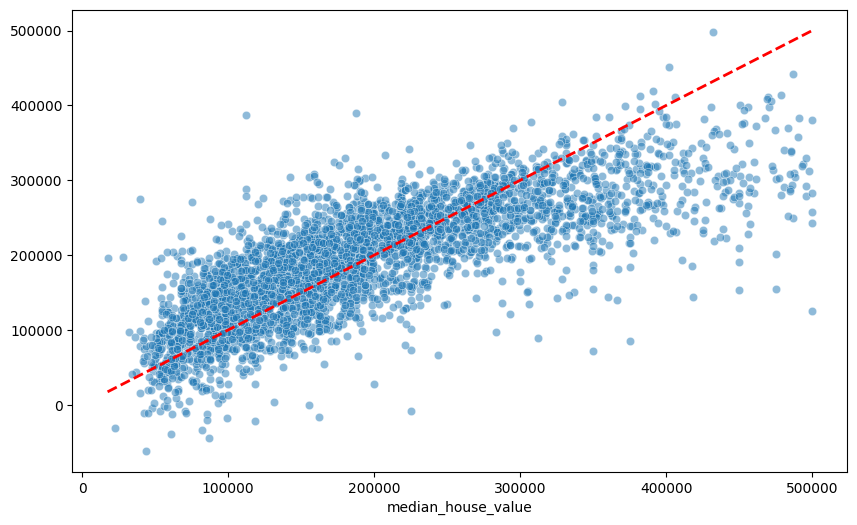

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Estandarizo los datos
final_lr = make_pipeline(StandardScaler(), LinearRegression())

# 2. Validación Cruzada
scores = cross_val_score(final_lr, X_train[features], y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f"RMSE validado (CV): ${-scores.mean():,.2f}")

# entrenamiento
final_lr.fit(X_train[features], y_train)

# predicciones
final_preds = final_lr.predict(X_test[features])
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
print(f"RMSE Final en Test Set: ${final_rmse:,.2f}")

# dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.show()

<font size="4">

**Con el RMSE del test para XGBoost (46,283.18) y para la regresión lineal (61,725.10) confirmamos que fue una buena decisión XGBoost.**

La información detallada de las conclusiones las presentaré a continuación, en los reportes operativo y directivo.

</font>

---
# **Reporte Operativo**: Análisis Predictivo de Viviendas

<font size="4">

**1. Resumen de la Situación Inicial**

* **Volumen de Datos:** Se analizaron inicialmente 20,640 registros de ubicaciones en California.
* **Variables Clave:** Se incluyeron datos geográficos (latitud, longitud), demográficos (población, habitaciones) y económicos (ingreso medio, valor de la vivienda).
* **Estado de los Datos:** Se detectaron 207 valores faltantes en la columna de dormitorios y una concentración inusual de precios topados a $500,001.

**2. Procesamiento y Limpieza (Acciones Operativas)**

*  **Filtrado de Sesgo:** Se eliminaron 965 registros con el precio máximo topado ($500,001) para evitar que el modelo aprendiera un sesgo incorrecto.

* **Tratamiento de Atípicos:** se eliminaron distritos con un ratio de habitantes por casa superior a 5.4, tras identificar registros erróneos de hasta 1,243 habitantes por vivienda. También se filtraron viviendas donde el 100% de las habitaciones eran dormitorios, por considerarse inconsistencias operativas.

*  **Imputación:** Los valores faltantes se completaron utilizando la mediana del conjunto de entrenamiento para garantizar la integridad de los datos.

**3. Hallazgos Técnicos y Selección de Variables**

* **Predictor Principal:** El ingreso medio (`median_income`) demostró ser la variable con mayor peso real en el precio de las casas (46.6% de importancia).

* **Nuevas Métricas:** Se crearon los ratios de "habitantes por casa" y "dormitorios por habitaciones" para mejorar la precisión del análisis.


* **Variables Seleccionadas:** Para los modelos finales se utilizaron: ingreso medio, ratio de habitantes, longitud y latitud.

**4. Resultados de los Modelos Predictivos**
Para cumplir con los objetivos del proyecto, se evaluaron dos tecnologías:

* **Modelo A (XGBoost):** Resultó ser el más eficiente con un error (RMSE) final de **$46,283.18**. Este modelo maneja mejor las variaciones naturales de los datos.

*  **Modelo B (Regresión Lineal):** Presentó un error significativamente mayor de **$61,725.10**, confirmando que las relaciones entre el precio y las variables no son puramente lineales.

**5. Conclusión Operativa**
El modelo **XGBoost** es el recomendado para la implementación, ya que ofrece una capacidad de generalización superior para predecir el valor del mercado inmobiliario, descartando el ruido estadístico previamente identificado.

</font>